In [1]:
import numpy as np
import pickle
import nibabel as nib
import os

from mbas.data.nifti import make_subject
from mbas.visualize.subject import plot_subject_with_label


from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

2024-09-04 21:49:48.846621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 21:49:48.868734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 21:49:49.309897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
preprocessed_folder = "/home/bryan/data/mbas_nnUNet_preprocessed/Dataset101_MBAS/MedNeXtPlans_3d_fullres"


subject_id = "MBAS_001"

npy = np.load(os.path.join(preprocessed_folder, f"{subject_id}.npy"))
npz = np.load(os.path.join(preprocessed_folder, f"{subject_id}.npz"))
with open(os.path.join(preprocessed_folder, f"{subject_id}.pkl"), "rb") as f:
    pkl = pickle.load(f)
seg_npy = np.load(os.path.join(preprocessed_folder, f"{subject_id}_seg.npy"))


# subject = make_subject(
#     f"/Users/bryan/data/MBAS_Dataset/Training/{subject_id}",
#     "train",
# )

In [3]:
pkl

{'sitk_stuff': {'spacing': (0.625, 0.625, 2.5),
  'origin': (-190.72938537597656, -180.62953186035156, -26.63135528564453),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)},
 'spacing': [2.5, 0.625, 0.625],
 'shape_before_cropping': (44, 640, 640),
 'bbox_used_for_cropping': [[0, 44], [1, 639], [1, 639]],
 'shape_after_cropping_and_before_resampling': (44, 638, 638),
 'class_locations': {1: array([[  0,  11, 284, 255],
         [  0,  25, 288, 289],
         [  0,   4, 270, 269],
         ...,
         [  0,  15, 345, 382],
         [  0,  20, 287, 255],
         [  0,   4, 239, 270]]),
  2: array([[  0,   7, 226, 297],
         [  0,   3, 323, 274],
         [  0,   9, 211, 295],
         ...,
         [  0,  12, 224, 308],
         [  0,  16, 243, 298],
         [  0,  10, 246, 270]]),
  3: array([[  0,  25, 332, 385],
         [  0,  25, 309, 327],
         [  0,  32, 337, 363],
         ...,
         [  0,  15, 318, 384],
         [  0,  31, 332, 338],
         [  0,  

In [4]:
pkl["class_locations"][1].shape

(10000, 4)

In [5]:
def plot_locations_basic(
    axes, locations, z_index = 15, color="green",
    plot_random_box=False,
    patch_size = (256, 256)
):
    """
    example location: array([  0,  16, 157, 165])
                                    Z, H, W
        
    """
    x_values = []
    y_values = []
    for location in locations:
        if location[1] == z_index:
            y_values.append(location[2])
            x_values.append(location[3])
    x_array = np.array(x_values)
    y_array = np.array(y_values)
    
#     print(f"x_array:  min {np.min(x_array)} max {np.max(x_array)}")
#     print(f"y_array:  min {np.min(y_array)} max {np.max(y_array)}")

    axes.scatter(x_array, y_array, s=2, alpha=1, c = color)
    if plot_random_box:
        selected_voxel_index = np.random.choice(len(x_values))
        # this is the box center point
        x_center = x_array[selected_voxel_index]
        y_center = y_array[selected_voxel_index]
        x_corner = max(x_center - patch_size[0] // 2, 0)
        y_corner = max(y_center - patch_size[1] // 2, 0)
        axes.add_patch(
            Rectangle((x_corner, y_corner),
            patch_size[0], patch_size[1],
                      facecolor="none", ec=color, lw=2)
        )
        axes.scatter([x_center,], [y_center,], s=200, alpha=1, c = color, marker="s")



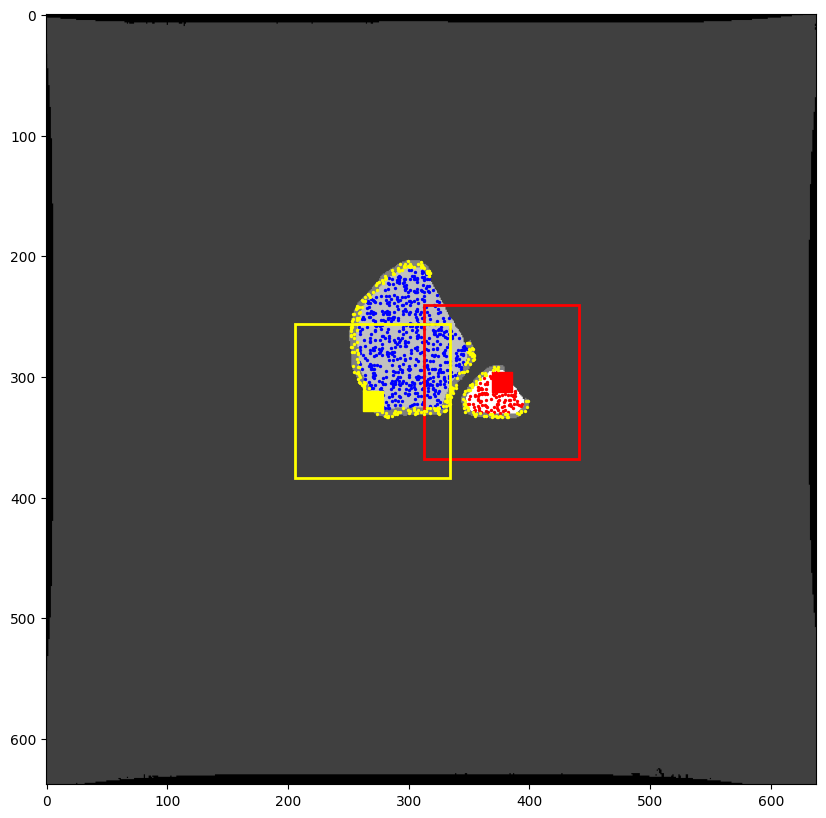

In [6]:
z_index = 10
# array = subject.label.data[0,:,:,z_index].numpy()

# seg_npy.shape, (1, 44, 638, 638)
array = seg_npy[0,z_index]
fig_basic, ax_basic = plt.subplots(figsize=(10,10))
ax_basic.imshow(array, cmap="gray")
plot_locations_basic(ax_basic, pkl["class_locations"][2], z_index = z_index, color="blue")
plot_locations_basic(ax_basic, pkl["class_locations"][3], z_index = z_index, color="red",
                     plot_random_box=True, patch_size = (128, 128))
plot_locations_basic(ax_basic, pkl["class_locations"][1], z_index = z_index, color="yellow",
                     plot_random_box=True, patch_size = (128, 128)
                    )

plt.show()

In [54]:
import random
from collections import defaultdict
class VoxelSelector:
    def __init__(self, z_coverage=False):
        self.sampled_z_indices = defaultdict(set)
        self.z_coverage = z_coverage
    
    def select_voxel(self, voxels_of_that_class, class_index = None):
        if self.z_coverage:
            all_z_indices = set(np.unique(voxels_of_that_class[:,1]))
            available_indices = all_z_indices - self.sampled_z_indices[class_index]
            if len(available_indices) == 0:
                available_indices = all_z_indices
                self.sampled_z_indices[class_index] = set()
            available_indices = list(available_indices)
            
            selected_z = available_indices[np.random.choice(len(available_indices))]
            filtered_voxels = voxels_of_that_class[voxels_of_that_class[:,1] == selected_z]
            selected_voxel = filtered_voxels[np.random.choice(len(filtered_voxels))]
            self.sampled_z_indices[class_index].add(selected_z)
        else: 
            selected_voxel = voxels_of_that_class[np.random.choice(len(voxels_of_that_class))]
        return selected_voxel